# Transfer Spend and Wage Bill Analysis or "Big Money = Big Results? An analysis of monetary variables contributing to Premier League success"

### Purpose
Every transfer window (the period in which players may be transferred to and from a team) in the Premier League there are fans who decry their Managers and Owners for not spending enough money to get higher value players, who they believe will contribute to the club's success. While thousands of fans make these claims, has it actually been proven that spending more money in the transfer window contributes to domestic league success? This analysis seeks to answer this question by investigating the relationship between club transfer spend and subsequent club success. I will be working with 3 distinct datasets (pl_table_2014_2024, pl_transfers_2014_2024_cleaned, and pl_wage_bill_2014_2024) for this analysis.

### Datasets
- pl_table_2014_2024: contains data for Premier League team performance by season.
- pl_transfers_2014_2024_cleaned: contains data for all transfers occurring between 2014 to 2024
- pl_wage_bill_2014_2024: contains data for team wage bills from 2014 to 2024

About the Data
* The data was collected via personally created Selenium web scraping techniques from various sources. These scripts may be found in the "Web Scraping Scripts" folder.
* Transfer data was collected from transfermarkt, a German website that receives user-inputted data in addition to using its own data collection techniques from football scouts and other professionals. source: https://www.transfermarkt.us/premier-league/transfers/wettbewerb/GB1/plus/?saison_id=2014&s_w=s&leihe=1&intern=0&intern=1
* Wage bill data was collected from FBRef, which its data from Capology, one of the leading data collectors for professional football salaries. source: https://fbref.com/en/comps/9/wages/Premier-League-Wages
* Match stats were collected from FBRef, as well. Premier League tables per season are created to ensure that match data is correct. source: https://fbref.com/en/comps/9/2019-2020/schedule/2019-2020-Premier-League-Scores-and-Fixtures
* Only data from 2014 to 2024 was collected, for the purposes of this analysis.

In [1]:
# Import relevant Python Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
# Read datasets into Data Frames

pl_table_df = pd.read_csv('../csvs/pl_table_2014_2024.csv', index_col = False)
pl_transfer_df = pd.read_csv('../csvs/pl_transfers_2014_2024_cleaned.csv', index_col = False)
pl_wage_df = pd.read_csv('../csvs/pl_wage_bill_2014_2024.csv', index_col = False)
pl_table_halves_df = pd.read_csv('../csvs/pl_table_halves_2014_2024.csv')


In [4]:
pl_transfer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8011 entries, 0 to 8010
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      8011 non-null   int64  
 1   Team            8011 non-null   object 
 2   Season          8011 non-null   object 
 3   Time            8011 non-null   object 
 4   Name            8011 non-null   object 
 5   Status          8011 non-null   object 
 6   Position        8011 non-null   object 
 7   Market Value    8011 non-null   float64
 8   Age             8011 non-null   int64  
 9   Fee             8011 non-null   float64
 10  is_loan         8011 non-null   int64  
 11  is_loan_return  8011 non-null   int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 751.2+ KB


In [5]:
pl_wage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Team          200 non-null    object
 1   Player Count  200 non-null    int64 
 2   Weekly Wages  200 non-null    object
 3   Annual Wages  200 non-null    object
 4   Season        200 non-null    object
dtypes: int64(1), object(4)
memory usage: 7.9+ KB


## Get Transfer Data from Transfer Dataset and Merge with Premier League Table Dataset

In [6]:
# Let's get the sum for transfer spend by time within season
agg_transfer_spend_in = pl_transfer_df[pl_transfer_df['Status'] == "In"].groupby(['Team', 'Season', 'Time'], as_index = False)['Fee'].sum()
agg_transfer_spend_in.head()

agg_transfer_spend_in[agg_transfer_spend_in['Team'] == "Tottenham Hotspur FC"]

,Team,Season,Time,Fee
325,Tottenham Hotspur FC,2014/2015,SUMMER,41850000.0
326,Tottenham Hotspur FC,2014/2015,WINTER,6630000.0
327,Tottenham Hotspur FC,2015/2016,SUMMER,71000000.0
328,Tottenham Hotspur FC,2016/2017,SUMMER,83500000.0
329,Tottenham Hotspur FC,2017/2018,SUMMER,92600000.0
330,Tottenham Hotspur FC,2017/2018,WINTER,28400000.0
331,Tottenham Hotspur FC,2018/2019,SUMMER,0.0
332,Tottenham Hotspur FC,2019/2020,SUMMER,116000000.0
333,Tottenham Hotspur FC,2019/2020,WINTER,34500000.0
334,Tottenham Hotspur FC,2020/2021,SUMMER,110500000.0


In [7]:
# Create and populate 'Transfer Spend Summer' field for every record based on Transfer Spend summations for each season in the Summer
pl_table_df['Transfer Spend Summer'] = 0

for team in pl_table_df['Team Name'].unique():
    for season in agg_transfer_spend_in[(agg_transfer_spend_in['Team'] == team)]['Season']:
        pl_table_df.loc[(pl_table_df['Team Name'] == team) & (pl_table_df['Season'] == season), 'Transfer Spend Summer'] = agg_transfer_spend_in.loc[(agg_transfer_spend_in['Team'] == team) & (agg_transfer_spend_in['Season'] == season) & (agg_transfer_spend_in['Time'] == "SUMMER"), "Fee"].item()

In [8]:
# Create and populate 'Transfer Spend Winter' field for every record based on Transfer Spend summations for each season in the Winter
pl_table_df['Transfer Spend Winter'] = 0.0

for team in pl_table_df['Team Name'].unique():
    for season in agg_transfer_spend_in[(agg_transfer_spend_in['Team'] == team)  & (agg_transfer_spend_in['Time'] == "WINTER")]['Season']:
        pl_table_df.loc[(pl_table_df['Team Name'] == team) & (pl_table_df['Season'] == season), 'Transfer Spend Winter'] = agg_transfer_spend_in.loc[(agg_transfer_spend_in['Team'] == team) & (agg_transfer_spend_in['Season'] == season) & (agg_transfer_spend_in['Time'] == "WINTER"), "Fee"].item()

In [9]:
# Create and populate 'Transfer Spend Summer' field for every record based on Transfer Spend summations for each season in the Summer
pl_table_halves_df['Transfer Spend Summer'] = 0

for team in pl_table_halves_df['Team Name'].unique():
    for season in agg_transfer_spend_in[(agg_transfer_spend_in['Team'] == team)]['Season']:
        pl_table_halves_df.loc[(pl_table_halves_df['Team Name'] == team) & (pl_table_halves_df['Season'] == season), 'Transfer Spend Summer'] = agg_transfer_spend_in.loc[(agg_transfer_spend_in['Team'] == team) & (agg_transfer_spend_in['Season'] == season) & (agg_transfer_spend_in['Time'] == "SUMMER"), "Fee"].item()

In [10]:
# Create and populate 'Transfer Spend Summer' field for every record based on Transfer Spend summations for each season in the Summer
pl_table_halves_df['Transfer Spend Winter'] = 0.0

for team in pl_table_halves_df['Team Name'].unique():
    for season in agg_transfer_spend_in[(agg_transfer_spend_in['Team'] == team) & (agg_transfer_spend_in['Time'] == "WINTER")]['Season']:
        print(agg_transfer_spend_in.loc[(agg_transfer_spend_in['Team'] == team) & (agg_transfer_spend_in['Season'] == season) & (agg_transfer_spend_in['Time'] == "WINTER"), "Fee"].item())
        pl_table_halves_df.loc[(pl_table_halves_df['Team Name'] == team) & (pl_table_halves_df['Season'] == season), 'Transfer Spend Winter'] = agg_transfer_spend_in.loc[(agg_transfer_spend_in['Team'] == team) & (agg_transfer_spend_in['Season'] == season) & (agg_transfer_spend_in['Time'] == "WINTER"), "Fee"].item()

0.0
0.0
0.0
34000000.0
0.0
77000000.0
21300000.0
0.0
2960000.0
0.0
9000000.0
11700000.0
17600000.0
2000000.0
0.0
0.0
0.0
0.0
32000000.0
1900000.0
5800000.0
21200000.0
11400000.0
0.0
30500000.0
27000000.0
0.0
12000000.0
7000000.0
6350000.0
0.0
11500000.0
7800000.0
1690000.0
0.0
24250000.0
15400000.0
22800000.0
68000.0
17250000.0
12500000.0
0.0
99850000.0
2500000.0
8000000.0
2000000.0
1800000.0
54800000.0
0.0
0.0
7000000.0
0.0
84650000.0
0.0
8500000.0
4350000.0
54000000.0
42000000.0
0.0
38700000.0
4200000.0
25150000.0
4500000.0
0.0
101100000.0
49000000.0
0.0
2560000.0
20900000.0
1700000.0
0.0
10000000.0
17500000.0
0.0
4200000.0
0.0
10900000.0
15800000.0
30000000.0
43000000.0
18500000.0
31000000.0
4600000.0
0.0
53800000.0
71800000.0
0.0
0.0
0.0
329500000.0
0.0
15480000.0
0.0
41700000.0
18750000.0
1150000.0
0.0
3500000.0
12180000.0
12000000.0
29100000.0
12840000.0
8800000.0
20200000.0
22800000.0
13800000.0
5200000.0
17000000.0
22000000.0
0.0
0.0
0.0
0.0
63250000.0
0.0
21900000.0
31800000.0

## Account for Inflation for More Accurate Analyses

In [11]:
# Adjust dollar amounts to 2014 Euro to account for inflation.
inflation_dict_summer = {
    "2014/2015": 1,
    "2015/2016": 1,
    "2016/2017": 1,
    "2017/2018": 1.02,
    "2018/2019": 1.04,
    "2019/2020": 1.05,
    "2020/2021": 1.06,
    "2021/2022": 1.09,
    "2022/2023": 1.19,
    "2023/2024": 1.27
}

inflation_dict_winter = {
    "2014/2015": 1,
    "2015/2016": 1,
    "2016/2017": 1.02,
    "2017/2018": 1.04,
    "2018/2019": 1.05,
    "2019/2020": 1.06,
    "2020/2021": 1.09,
    "2021/2022": 1.19,
    "2022/2023": 1.27,
    "2023/2024": 1.3
}

divisor_summer = pl_table_df['Season'].map(inflation_dict_summer)
divisor_winter = pl_table_df['Season'].map(inflation_dict_winter)

pl_table_df['Transfer Spend Summer'] = (pl_table_df['Transfer Spend Summer'] / divisor_summer)
pl_table_df['Transfer Spend Winter'] = (pl_table_df['Transfer Spend Winter'] / divisor_winter)

pl_table_halves_df['Transfer Spend Summer'] = (pl_table_halves_df['Transfer Spend Summer'] / divisor_summer)
pl_table_halves_df['Transfer Spend Winter'] = (pl_table_halves_df['Transfer Spend Winter'] / divisor_winter)

### Summer Transfer Spend per Season

As we can see from the boxplot above, Summer Transfer Spend has increased consistently season-over-season from 2014 to 2023, even adjusted for inflation, with a slight drop in 2020/2021 and 2021/2022, which was may be accounted for by the COVID pandemic.

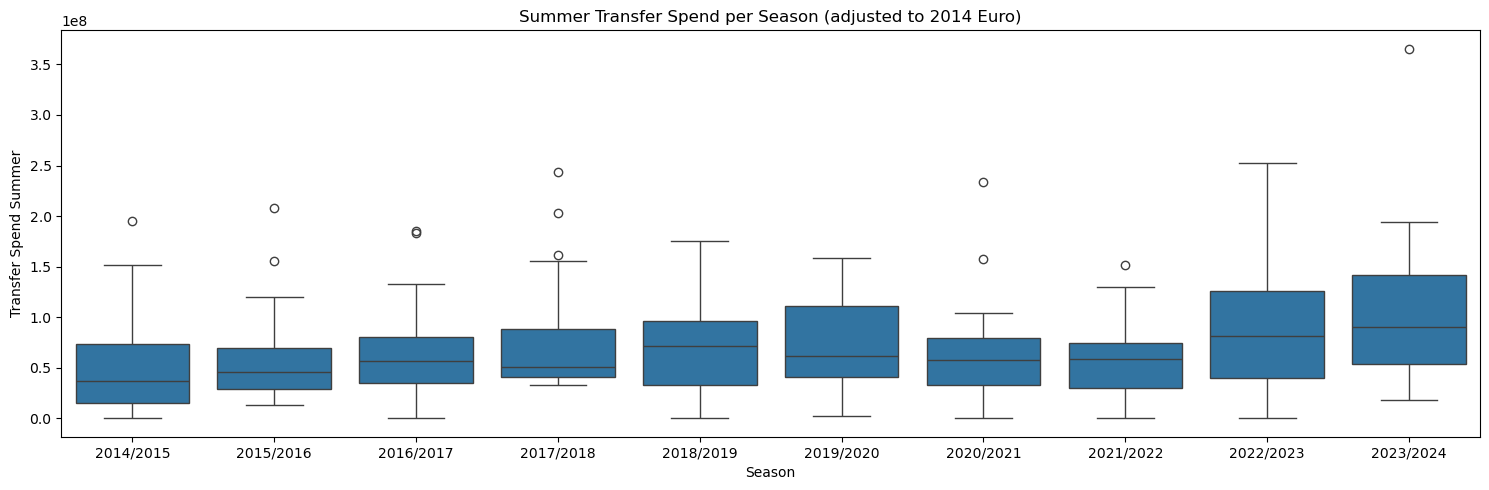

In [12]:
# Summer transfer spend from 2014 to 2024, adjusted to 2014 Euro
# As we can see, overall transfer spend during the summer has been increasing from year-to-year, even adjusted for inflation

plt.figure(figsize = (15, 5))
sns.boxplot(data = pl_table_df, x = 'Season', y = 'Transfer Spend Summer')
plt.title('Summer Transfer Spend per Season (adjusted to 2014 Euro)')
plt.tight_layout()

### Winter Transfer Spend per Season
Winter Transfer Spend presents a different trend than Summer Transfer Spend, as Transfer Spend in the Winter appears to ber following a more undulating pattern. This may be attributed to the needs-basis for Winter transfers. Premier League teams will only be spending in the Winter if there is an absolute need for a player of a specific position, as there are many factors that would make mid-season integration into the team difficult for new players. Variation could be attributed to higher injury rates in certain seasons, necessitating more transfers in that season, but further research would need to be conducted to better understand this variation.

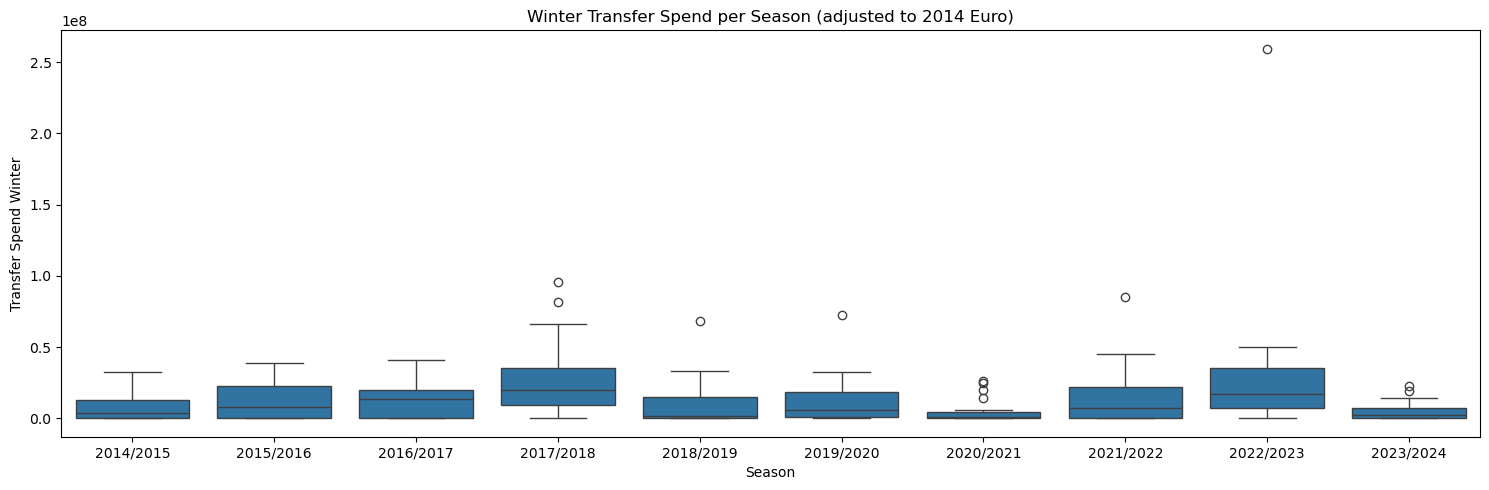

In [13]:
# Winter transfer spend from 2014 to 2024, adjusted to 2014 Euro
# Winter transfer spend tends to fluctuate a bit more 

plt.figure(figsize = (15, 5))
sns.boxplot(data = pl_table_df, x = 'Season', y = 'Transfer Spend Winter')
plt.title('Winter Transfer Spend per Season (adjusted to 2014 Euro)')
plt.tight_layout()

In [14]:
# Populate 'Wage Bill' field for each record in pl_table_df with corresponding 'Annual Wages' value in pl_wage_df.

for team in pl_table_df['Team Name'].unique():
    for season in pl_table_df[pl_table_df['Team Name'] == team]['Season']:
        pl_table_df.loc[(pl_table_df['Team Name'] == team) & (pl_table_df['Season'] == season), 'Wage Bill'] = pl_wage_df.loc[(pl_wage_df['Team'] == team) & (pl_wage_df['Season'] == season), 'Annual Wages'].item()

pl_table_df['Wage Bill'] = pl_table_df['Wage Bill'].str.replace(",", "").astype(float)

pl_table_df['Wage Bill'] = (pl_table_df['Wage Bill'] / divisor_summer).round(2)

# Visualizations with Wage Bill and Transfer Spend

### Annual Wage Bill vs Season Placement

Based on the data, it appears that Annual Wage Bill is positively correlated with Season Placement to some degree. 

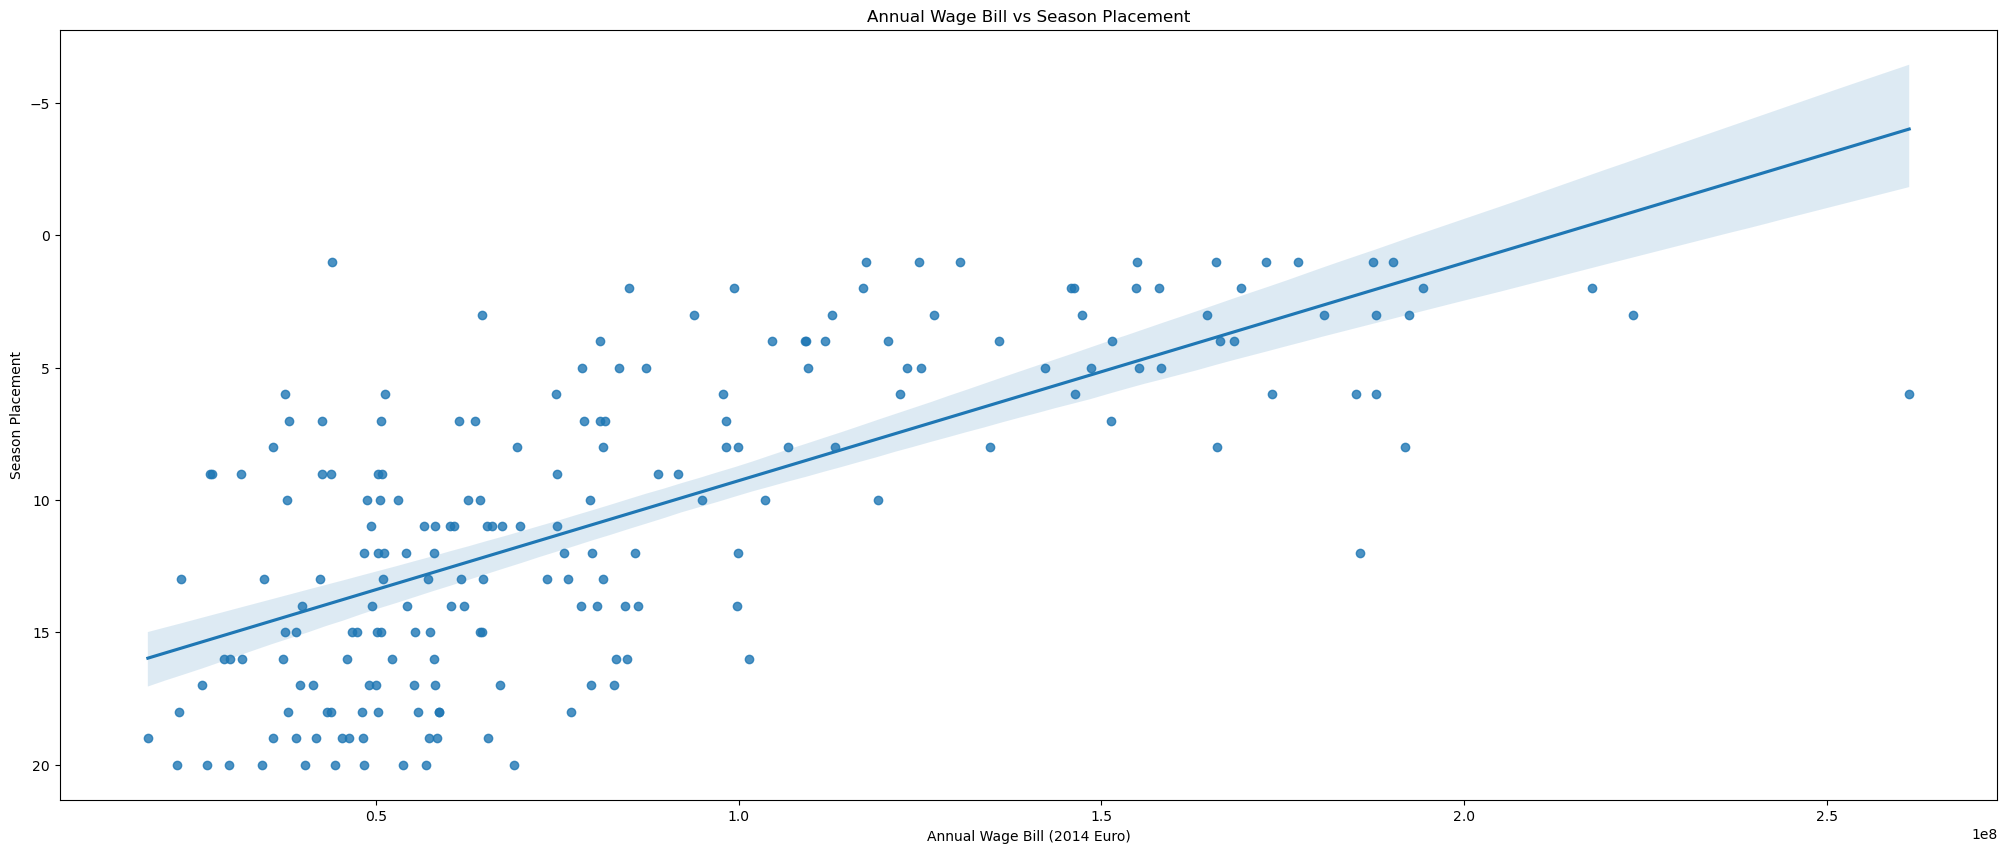

In [15]:
# Plot annual wage bill vs season placement

plt.figure(figsize = (25, 10))

scatter_plot = sns.regplot(data = pl_table_df, x = 'Wage Bill', y = 'Place')

scatter_plot.invert_yaxis()

plt.title('Annual Wage Bill vs Season Placement')
plt.ylabel('Season Placement')
plt.xlabel('Annual Wage Bill (2014 Euro)')

plt.show()


### Summer Transfer Spend vs Season Placement

There also exists a loose positive correlation between Summer Transfer Spend and Season Placement.

<function matplotlib.pyplot.ylabel(ylabel: 'str', fontdict: 'dict[str, Any] | None' = None, labelpad: 'float | None' = None, *, loc: "Literal['bottom', 'center', 'top'] | None" = None, **kwargs) -> 'Text'>

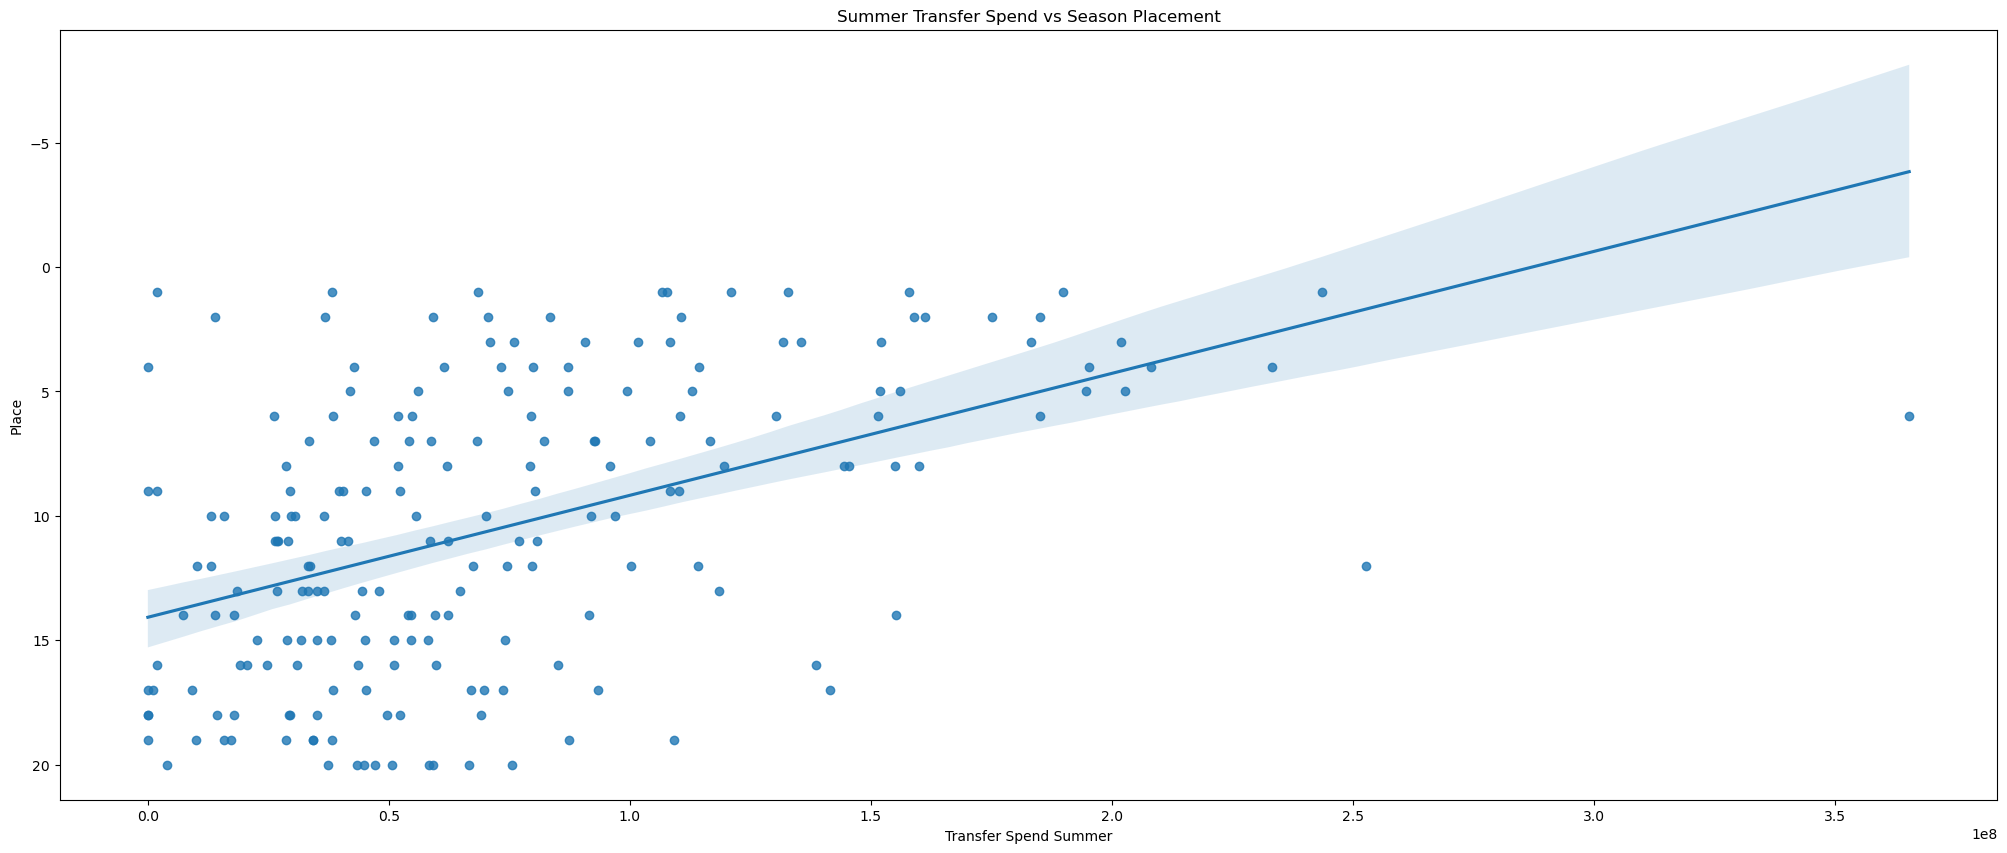

In [30]:
#Plot summer transfer spend vs season placement
plt.figure(figsize = (25, 10))

sns.regplot(data = pl_table_df, x = 'Transfer Spend Summer', y = 'Place').invert_yaxis()
plt.title('Summer Transfer Spend vs Season Placement')
plt.ylabel

# New Metrics for Further Analysis

- Points Improvement: Change in Points from previous season to current season.
- Place Improvement: Change in Place from previous season to current season.
- Wage Bill Increase: Change in Wage Bill from previous season to current season (not necessarily an increase, despite the name).

In [18]:
# Create improvement metric from previous season for points

pl_table_df['Points Improvement'] = 0.0

for season in pl_table_df['Season'].unique():
    temp_df = pl_table_df[pl_table_df['Season'] == season]
    prev_season = (str(int(season.split('/')[0]) - 1) + '/' + str(int(season.split('/')[1]) - 1))

    if season == '2014/2015':
        pl_table_df.loc[(pl_table_df['Team Name'] == team) & (pl_table_df['Season'] == season), "Points Improvement"] = None
    else:
        for team in temp_df['Team Name']:
            if pl_table_df.loc[(pl_table_df['Team Name'] == team) & (pl_table_df['Season'] == prev_season), "Points"].empty == False:
                pl_table_df.loc[(pl_table_df['Team Name'] == team) & (pl_table_df['Season'] == season), "Points Improvement"] = pl_table_df.loc[(pl_table_df['Team Name'] == team) & (pl_table_df['Season'] == season), "Points"].item() - pl_table_df.loc[(pl_table_df['Team Name'] == team) & (pl_table_df['Season'] == prev_season), "Points"].item()
            else:
                pl_table_df.loc[(pl_table_df['Team Name'] == team) & (pl_table_df['Season'] == season), "Points Improvement"] = None
        
pl_table_df[pl_table_df['Season'] != "2014/2015"].head(10)
pl_table_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             200 non-null    int64  
 1   Team Name              200 non-null    object 
 2   Season                 200 non-null    object 
 3   W                      200 non-null    int64  
 4   L                      200 non-null    int64  
 5   D                      200 non-null    int64  
 6   GF                     200 non-null    int64  
 7   GF_H                   200 non-null    int64  
 8   GF_A                   200 non-null    int64  
 9   GA                     200 non-null    int64  
 10  GA_H                   200 non-null    int64  
 11  GA_A                   200 non-null    int64  
 12  GD                     200 non-null    int64  
 13  Points                 200 non-null    int64  
 14  Place                  200 non-null    int64  
 15  Transf

In [19]:
# Create improvement metric from previous season for placement

pl_table_df['Place Improvement'] = 0

for season in pl_table_df['Season'].unique():
    temp_df = pl_table_df[pl_table_df['Season'] == season]
    prev_season = (str(int(season.split('/')[0]) - 1) + '/' + str(int(season.split('/')[1]) - 1))

    if season == '2014/2015':
        pl_table_df.loc[(pl_table_df['Team Name'] == team) & (pl_table_df['Season'] == season), "Place Improvement"] = None
    else:
        for team in temp_df['Team Name']:
            if pl_table_df.loc[(pl_table_df['Team Name'] == team) & (pl_table_df['Season'] == prev_season), "Place"].empty == False:
                pl_table_df.loc[(pl_table_df['Team Name'] == team) & (pl_table_df['Season'] == season), "Place Improvement"] = (pl_table_df.loc[(pl_table_df['Team Name'] == team) & (pl_table_df['Season'] == season), "Place"].item() - pl_table_df.loc[(pl_table_df['Team Name'] == team) & (pl_table_df['Season'] == prev_season), "Place"].item())
            else:
                pl_table_df.loc[(pl_table_df['Team Name'] == team) & (pl_table_df['Season'] == season), "Place Improvement"] = None


pl_table_df[pl_table_df['Season'] != "2014/2015"].head(10)

,Unnamed: 0,Team Name,Season,W,L,D,GF,GF_H,GF_A,GA,GA_H,GA_A,GD,Points,Place,Transfer Spend Summer,Transfer Spend Winter,Wage Bill,Points Improvement,Place Improvement
20,11,Leicester City FC,2015/2016,23,3,12,68,35,33,36,18,18,32,81,1,38200000.0,11700000.0,43979401.0,40.0,-13.0
21,61,Arsenal FC,2015/2016,20,7,11,65,31,34,36,11,25,29,71,2,14000000.0,12500000.0,117097928.0,-4.0,-1.0
22,161,Tottenham Hotspur FC,2015/2016,19,6,13,69,35,34,35,15,20,34,70,3,71000000.0,0.0,64694251.0,6.0,-2.0
23,1,Manchester United FC,2015/2016,19,10,9,49,27,22,35,9,26,14,66,5,156000000.0,0.0,148561362.0,-4.0,1.0
24,191,Manchester City FC,2015/2016,19,10,9,71,47,24,41,21,20,30,66,4,208150000.0,320000.0,151403244.0,-13.0,2.0
25,141,Southampton FC,2015/2016,18,11,9,59,39,20,41,22,19,18,63,6,54900000.0,5200000.0,51260009.0,3.0,-1.0
26,21,West Ham United FC,2015/2016,16,8,14,65,34,31,51,26,25,14,62,7,46900000.0,5800000.0,63603053.0,15.0,-5.0
27,71,Liverpool FC,2015/2016,16,10,12,63,33,30,50,22,28,13,60,8,119500000.0,7000000.0,113242366.0,-2.0,2.0
28,41,Stoke City FC,2015/2016,14,15,9,41,22,19,55,24,31,-14,51,9,29400000.0,24250000.0,50276143.0,-3.0,0.0
29,111,Chelsea FC,2015/2016,12,12,14,59,32,27,53,30,23,6,50,10,91900000.0,4600000.0,119183724.0,-37.0,9.0


In [20]:
# Create wage bill increase metric - current year wage bill minus previous year wage bill

pl_table_df['Wage Bill Increase'] = 0

for season in pl_table_df['Season'].unique():
    temp_df = pl_table_df[pl_table_df['Season'] == season]
    prev_season = (str(int(season.split('/')[0]) - 1) + '/' + str(int(season.split('/')[1]) - 1))

    if season == '2014/2015':
        pl_table_df.loc[(pl_table_df['Team Name'] == team) & (pl_table_df['Season'] == season), "Wage Bill Increase"] = None
    else:
        for team in temp_df['Team Name']:
            if pl_table_df.loc[(pl_table_df['Team Name'] == team) & (pl_table_df['Season'] == prev_season), "Wage Bill"].empty == False:
                pl_table_df.loc[(pl_table_df['Team Name'] == team) & (pl_table_df['Season'] == season), "Wage Bill Increase"] = (pl_table_df.loc[(pl_table_df['Team Name'] == team) & (pl_table_df['Season'] == season), "Wage Bill"].item() - pl_table_df.loc[(pl_table_df['Team Name'] == team) & (pl_table_df['Season'] == prev_season), "Wage Bill"].item())
            else:
                pl_table_df.loc[(pl_table_df['Team Name'] == team) & (pl_table_df['Season'] == season), "Wage Bill Increase"] = None


pl_table_df[pl_table_df['Season'] != "2014/2015"].head(10)

,Unnamed: 0,Team Name,Season,W,L,D,GF,GF_H,GF_A,GA,...,GA_A,GD,Points,Place,Transfer Spend Summer,Transfer Spend Winter,Wage Bill,Points Improvement,Place Improvement,Wage Bill Increase
20,11,Leicester City FC,2015/2016,23,3,12,68,35,33,36,...,18,32,81,1,38200000.0,11700000.0,43979401.0,40.0,-13.0,4126275.0
21,61,Arsenal FC,2015/2016,20,7,11,65,31,34,36,...,25,29,71,2,14000000.0,12500000.0,117097928.0,-4.0,-1.0,4189482.0
22,161,Tottenham Hotspur FC,2015/2016,19,6,13,69,35,34,35,...,20,34,70,3,71000000.0,0.0,64694251.0,6.0,-2.0,-13764579.0
23,1,Manchester United FC,2015/2016,19,10,9,49,27,22,35,...,26,14,66,5,156000000.0,0.0,148561362.0,-4.0,1.0,-19733371.0
24,191,Manchester City FC,2015/2016,19,10,9,71,47,24,41,...,20,30,66,4,208150000.0,320000.0,151403244.0,-13.0,2.0,5557354.0
25,141,Southampton FC,2015/2016,18,11,9,59,39,20,41,...,19,18,63,6,54900000.0,5200000.0,51260009.0,3.0,-1.0,508033.0
26,21,West Ham United FC,2015/2016,16,8,14,65,34,31,51,...,25,14,62,7,46900000.0,5800000.0,63603053.0,15.0,-5.0,9391448.0
27,71,Liverpool FC,2015/2016,16,10,12,63,33,30,50,...,28,13,60,8,119500000.0,7000000.0,113242366.0,-2.0,2.0,15416285.0
28,41,Stoke City FC,2015/2016,14,15,9,41,22,19,55,...,31,-14,51,9,29400000.0,24250000.0,50276143.0,-3.0,0.0,6493516.0
29,111,Chelsea FC,2015/2016,12,12,14,59,32,27,53,...,23,6,50,10,91900000.0,4600000.0,119183724.0,-37.0,9.0,-5611017.0


# Visualizations with New Metrics

### Points Improvement vs Summer Transfer Spend

As we can see from the graph below, there appears to be no correlation between transfer spend in the Summer before the current season and the points improvement from the previous season to the current season.

Text(0.5, 1.0, 'Points Improvement vs Summer Transfer Spend (2014 Euro)')

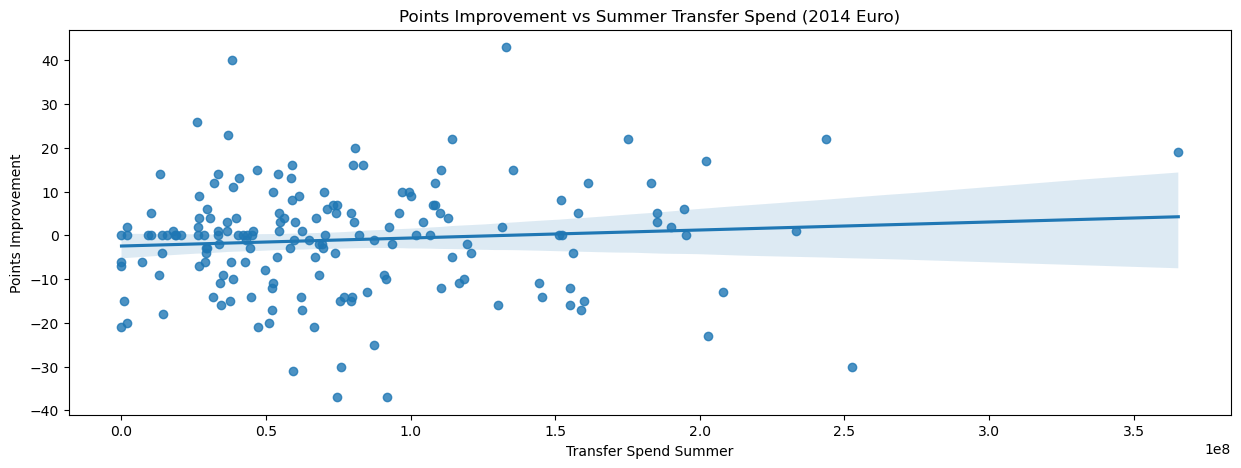

In [21]:
# Points Improvement vs Transfer Spend Summer

plt.figure(figsize = (15,5))

sns.regplot(data = pl_table_df, x = 'Transfer Spend Summer', y = 'Points Improvement')
plt.title('Points Improvement vs Summer Transfer Spend (2014 Euro)')

### Place Improvement vs Summer Transfer Spend

When we examine Place Improvement vs Summer Transfer Spend, we find no correlation between transfer spend in the Summer and place improvement from the previous season to the current season, which should be expected, as Summer Transfer Spend had little-to-no correlation to points improvement.

Text(0.5, 1.0, 'Place Improvement vs Summer Transfer Spend')

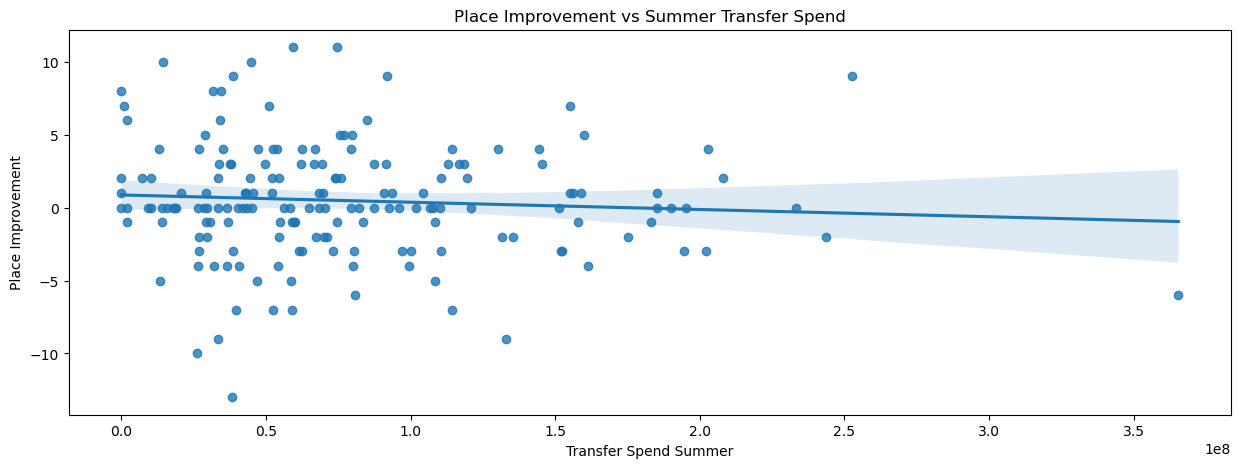

In [22]:
# Place Improvement vs Transfer Spend Summer

plt.figure(figsize = (15,5))

sns.regplot(data = pl_table_df, x = 'Transfer Spend Summer', y = 'Place Improvement')
plt.title('Place Improvement vs Summer Transfer Spend')

### Place Improvement vs Wage Bill Increase

When examining Wage Bill Increase's effect on Place Improvement, we find that there is a very slight positive correlation between Wage Bill Increase and Place Improvement. However, this is positive correlation is extremely minimal.

Text(0.5, 1.0, 'Place Improvement vs Wage Bill Increase')

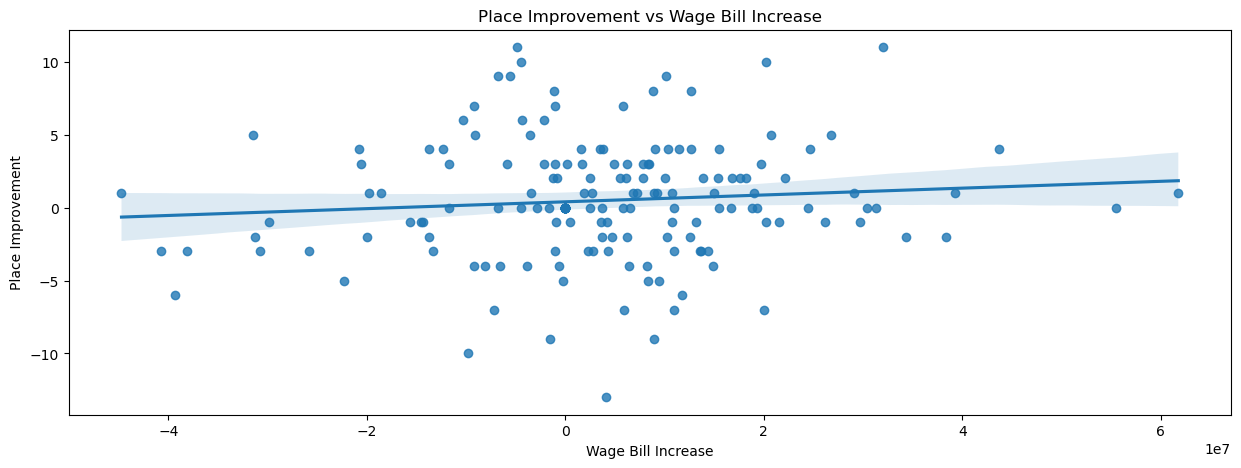

In [23]:
# Place Improvement vs Wage Bill Increase

plt.figure(figsize = (15,5))

sns.regplot(data = pl_table_df, x = 'Wage Bill Increase', y = 'Place Improvement')
plt.title('Place Improvement vs Wage Bill Increase')

### Points Improvement vs Wage Bill Increase

As shown by the graph below, Wage Bill Increase also has a negligible effect on points improvement from season-to-season.

Text(0.5, 1.0, 'Points Improvement from Previous Season vs Wage Bill Increase')

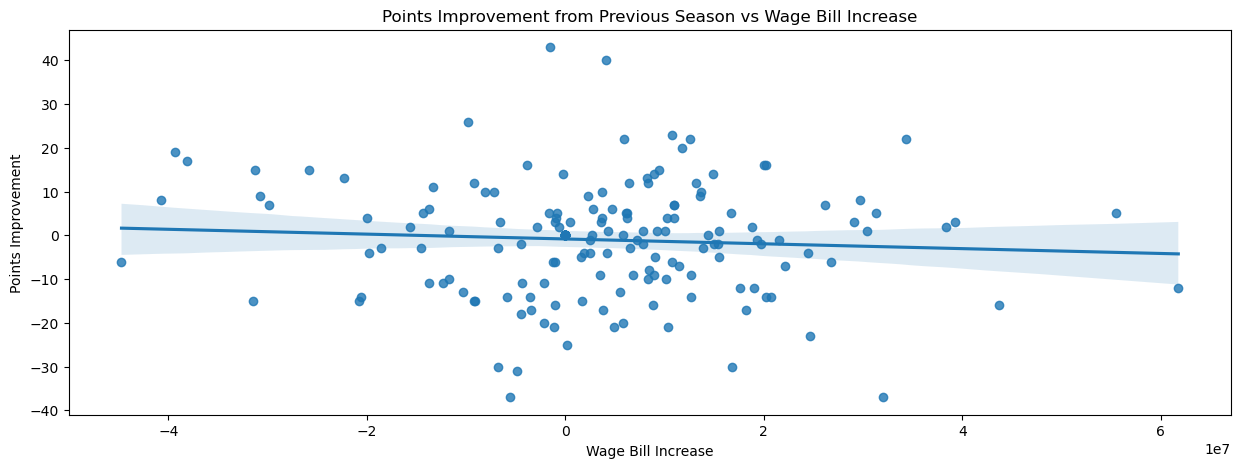

In [24]:
# Points Improvement from previous season vs Wage Bill Increase
plt.figure(figsize = (15,5))

sns.regplot(data = pl_table_df, x = 'Wage Bill Increase', y = 'Points Improvement')
plt.title("Points Improvement from Previous Season vs Wage Bill Increase")

### Add Location Data to Existing Dataset for Further Visualizations

In [25]:
# Create Data Frame with location data (lat, lon) for team's stadium and previously created features
# Add Lat-Lon data to existing pl_table Data Frame

loc_df = pd.read_csv('../csvs/pl_stadiums_loc.csv')

for team in pl_table_df['Team Name'].unique():
    for season in pl_table_df[pl_table_df['Team Name'] == team]['Season']:
        pl_table_df.loc[(pl_table_df['Team Name'] == team) & (pl_table_df['Season'] == season), "Lat"] = loc_df.loc[loc_df['Team'] == team, "Latitude"].item()
        pl_table_df.loc[(pl_table_df['Team Name'] == team) & (pl_table_df['Season'] == season), "Lon"] = loc_df.loc[loc_df['Team'] == team, "Longitude"].item()

## Linear Regression Analyses

Based on the R-Squared values calculated from the Linear Regression models below, there are slightly weak correlations for Place dependency on Wage Bill (.49) and for Points dependency on Wage Bill (.50). The data seems to suggest that Wage Bill correlates positively to placement and points in a given season.

In [ ]:
# Linear Regressions on Placement/Points vs Wage Bill

x = pl_table_df['Wage Bill'].to_numpy().reshape(pl_table_df['Wage Bill'].count(), 1)
y = pl_table_df['Place'].to_numpy().reshape(pl_table_df['Place'].count(), 1)

# Create and train Linear Regression model
model = LinearRegression()
model.fit(x, y)

y_pred = model.predict(x)

r_squared = r2_score(y, y_pred)
print(f"R-squared for Place dependency on Wage Bill: {r_squared}")

x_points = pl_table_df['Wage Bill'].to_numpy().reshape(pl_table_df['Wage Bill'].count(), 1)
y_points = pl_table_df['Points'].to_numpy().reshape(pl_table_df['Points'].count(), 1)

# Create and train Linear Regression model
model_points = LinearRegression()
model_points.fit(x_points, y_points)

y_pred_points = model_points.predict(x_points)

r_squared_points = r2_score(y_points, y_pred_points)
print(f"R-squared for Points dependency on Wage Bill: {r_squared_points}")





R-squared for Place dependency on Wage Bill: 0.4855615920939911
R-squared for Points dependency on Wage Bill: 0.49804764409030167


Wage Bill Increase appears to have no correlation with Placement/Points Improvement season-to-season.

In [ ]:
# Linear Regressions on Placement/Points Improvement vs Wage Bill Increase

x = pl_table_df[~pl_table_df['Wage Bill Increase'].isna()]['Wage Bill Increase'].to_numpy().reshape(pl_table_df['Wage Bill Increase'].count(), 1)
y = pl_table_df[~pl_table_df['Wage Bill Increase'].isna()]['Place Improvement'].to_numpy().reshape(pl_table_df['Place Improvement'].count(), 1)

# Create and train Linear Regression model
model = LinearRegression()
model.fit(x, y)

y_pred = model.predict(x)

r_squared = r2_score(y, y_pred)
print(f"R-squared for Place Improvement dependency on Wage Bill Increase: {r_squared}")

x_points = pl_table_df[~pl_table_df['Wage Bill Increase'].isna()]['Wage Bill Increase'].to_numpy().reshape(pl_table_df['Wage Bill Increase'].count(), 1)
y_points = pl_table_df[~pl_table_df['Wage Bill Increase'].isna()]['Points Improvement'].to_numpy().reshape(pl_table_df['Points Improvement'].count(), 1)

# Create and train Linear Regression model
model_points = LinearRegression()
model_points.fit(x_points, y_points)

y_pred_points = model_points.predict(x_points)

r_squared_points = r2_score(y_points, y_pred_points)
print(f"R-squared for Points Improvement dependency on Wage Bill Increase: {r_squared_points}")

R-squared for Place dependency on Wage Bill: 0.009074139270921933
R-squared for Points dependency on Wage Bill: 0.005072101516678251


Based on the R-Squared values calculated from the Linear Regression models below, there are very weak positive correlations for Place dependency on Transfer Spend (.23) and for Points dependency on Transfer Spend (.23). The data seems to suggest a weak positive correlation between points/placement and transfer spend.

In [ ]:
# Linear Regressions on placement/points vs transfer spend

x = pl_table_df['Transfer Spend Summer'].to_numpy().reshape(pl_table_df['Transfer Spend Summer'].count(), 1)
y = pl_table_df['Place'].to_numpy().reshape(pl_table_df['Place'].count(), 1)

# Create and train Linear Regression model
model = LinearRegression()
model.fit(x, y)

y_pred = model.predict(x)

r_squared = r2_score(y, y_pred)
print(f"R-squared for Place dependency on Summer Transfer Spend: {r_squared}")

x_points = pl_table_df['Transfer Spend Summer'].to_numpy().reshape(pl_table_df['Transfer Spend Summer'].count(), 1)
y_points = pl_table_df['Points'].to_numpy().reshape(pl_table_df['Points'].count(), 1)

# Create and train Linear Regression model
model_points = LinearRegression()
model_points.fit(x_points, y_points)

y_pred_points = model_points.predict(x_points)

r_squared_points = r2_score(y_points, y_pred_points)
print(f"R-squared for Points dependency on Summer Transfer Spend: {r_squared_points}")


R-squared for Place dependency on Wage Bill: 0.2358378953289727
R-squared for Points dependency on Wage Bill: 0.226079643478167


There also appears to be an entirely negligible correlation between Summer Transfer Spend and Placement/Points Improvement from season-to-season.

In [38]:
# Linear Regressions on Placement/Points Improvement vs Transfer Spend Summer

x = pl_table_df[~pl_table_df['Points Improvement'].isna()]['Transfer Spend Summer'].to_numpy().reshape(pl_table_df[~pl_table_df['Points Improvement'].isna()]['Transfer Spend Summer'].count(), 1)
y = pl_table_df[~pl_table_df['Place Improvement'].isna()]['Place Improvement'].to_numpy().reshape(pl_table_df[~pl_table_df['Points Improvement'].isna()]['Place Improvement'].count(), 1)

# Create and train Linear Regression model
model = LinearRegression()
model.fit(x, y)

y_pred = model.predict(x)

r_squared = r2_score(y, y_pred)
print(f"R-squared for Place Improvement dependency on Summer Transfer Spend: {r_squared}")

x_points = pl_table_df[~pl_table_df['Points Improvement'].isna()]['Transfer Spend Summer'].to_numpy().reshape(pl_table_df[~pl_table_df['Points Improvement'].isna()]['Transfer Spend Summer'].count(), 1)
y_points = pl_table_df[~pl_table_df['Points Improvement'].isna()]['Points Improvement'].to_numpy().reshape(pl_table_df[~pl_table_df['Points Improvement'].isna()]['Points Improvement'].count(), 1)

# Create and train Linear Regression model
model_points = LinearRegression()
model_points.fit(x_points, y_points)

y_pred_points = model_points.predict(x_points)

r_squared_points = r2_score(y_points, y_pred_points)
print(f"R-squared for Points Improvement dependency on Summer Transfer Spend: {r_squared_points}")

R-squared for Place Improvement dependency on Summer Transfer Spend: 0.005452487784296967
R-squared for Points Improvement dependency on Summer Transfer Spend: 0.007392114125323257


# Conclusion

Based on the available data from 2014 to 2024 and the above analyses, Premier League transfer spend does not appear to have a strong positive correlation with Placement Improvement (R^2: .005) nor Points Improvement (R^2: .007) from season-to-season. However, there does exist a positive correlation between Annual Wage Bill and both Placement (R^2: .49) and Points (R^2: .5). Though this would seem to suggest that higher wage bills lead to better subsequent season performance, Wage Bill Increase from season-to-season did not appear to  correlate with Place Improvement nor Points Improvement. One way this may explained is that Premier League teams with high Annual Wage Bills are typically the larger, more dominant teams in the Premier League. In fact, when we examine the PL table sorted by Wage Bill, we find the same 6 teams in the top 50 Wage Bills for given seasons. This seems to suggest that the largest 6 clubs (typically referred to as the Big 6) are regularly dominant in the Premier League (as shown in the last table featuring top 8 finishes by the top 50 Wage Bills), which would explain why Wage Bill Increase alone does not result in better subsequent season performance.

In conclusion, it would appear that, despite what many football fans may think, spending more money in the transfer window does not seem to produce better results in the subsequent season.

### Limitations
- There are some limitations with this analysis, namely the source of the data. Data scraped from the transfermarkt website could include user-inputted data, which may be inaccurate for individual transfer fees and/or Market Value valuations of players.

### Further Research
Given the data that was gathered during this analysis project, there are plenty of interesting questions outside the scope of this project that could be investigated regarding various attributes' effects on club performance season-to-season:
1. How does position distribution at the club affect performance in season?
2. Does wage bill spend per position affect certain stats in a season (e.g. does having a higher paid striker necessarily lead to better G/A output for the team)?
3. Does transfer spend in the Winter correlate to better performance in the 2nd half of the season?
4. Is there a minimum wage bill required to not get relegated in a season?

In [97]:
# Highlight rows by placement

def highlight_placement(row):
        if row['Place'] <= 6.0:
            return ['background-color: darkgreen'] * len(row) 
        elif row['Place'] < 10:
             return ['background-color: orange; color: black'] * len(row)
        elif row['Place'] >= 10:
             return ['background-color: darkred'] * len(row)
        else:
            return [''] * len(row)

In [98]:
#######################################################
#          Top 50 Wage Bill Teams and Seasons         #
# Top 6 Finishes for Big 6 teams highlighted in green #
# Bottom 10 finishes highlighted in red               #
# 7-9 finishes are highlighted in orange              #
#######################################################

pl_table_df[['Team Name', 'Season', 'Place', 'Wage Bill']].sort_values(by = "Wage Bill", ascending = False).head(50).reset_index().drop(columns = ["index"]).style.apply(highlight_placement, axis = 1)

,Team Name,Season,Place,Wage Bill
0,Manchester United FC,2021/2022,6,261324842.200000
1,Manchester United FC,2022/2023,3,223208481.510000
2,Manchester United FC,2020/2021,2,217598055.660000
3,Manchester United FC,2017/2018,2,194283990.200000
4,Chelsea FC,2021/2022,3,192440556.880000
5,Manchester United FC,2023/2024,8,191772093.700000
6,Manchester City FC,2022/2023,1,190218626.050000
7,Manchester United FC,2019/2020,3,187902766.670000
8,Manchester United FC,2016/2017,6,187838480.000000
9,Manchester City FC,2023/2024,1,187369152.760000
